# Creating "Normal" Models 

This notebook will detail how three algorithms—Rolling Mean, ARIMA, and Autoencoder—create "normal" models from my five time series datasets. In other words, this will perform the left half of the following diagram.

<img src="explore/Experiments_Diagram.jpg">



## First let's import everything and plots the datasets:

In [2]:
# Standard modules
import os
import sys
import datetime
import pandas as pd
from pandas import datetime
from pandas import read_csv
import numpy as np
from matplotlib import pyplot
import progressbar
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMAResults
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard
from keras.layers.advanced_activations import LeakyReLU
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from tensorflow import set_random_seed
#sys.path.append(os.path.abspath('/Users/shawnpolson/Documents/School/Spring 2019/Independent Study/Code/GitHub-Satellite-Telemetry-Anomaly-Detection/Satellite-Telemetry-Anomaly-Detection/Generate_Rolling_Mean_RMSEs.py.py'))

# Custom modules
from Generate_Rolling_Mean_RMSEs import * 
from detect_anomalies_with_rolling_mean import *
from model_with_rolling_mean import *
from correlate import correlation
from model_with_arima import *
from model_with_autoencoder import *

In [3]:
datasets = ['Data/BusVoltage.csv', 'Data/TotalBusCurrent.csv', 'Data/BatteryTemperature.csv', 'Data/WheelTemperature.csv', 'Data/WheelRPM.csv']
var_names = ['Voltage (V)', 'Current (A)', 'Temperature (C)', 'Temperature (C)', 'RPM']

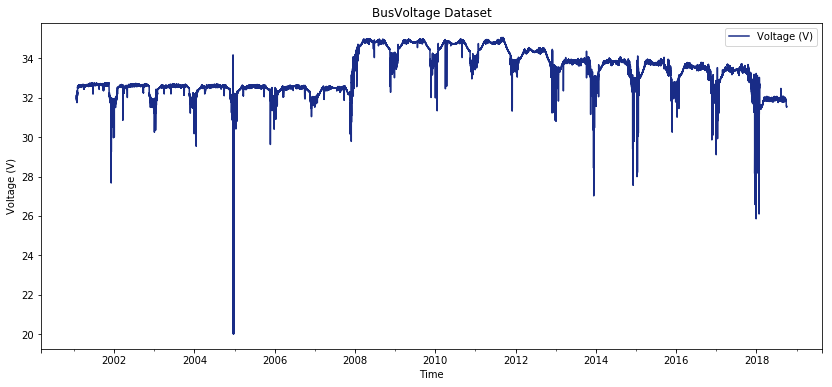

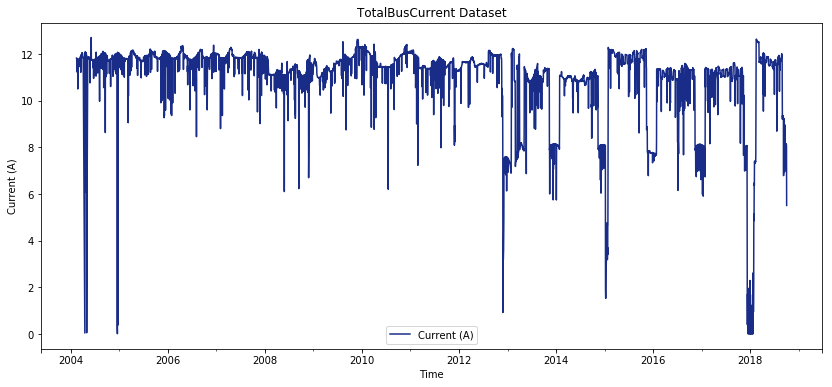

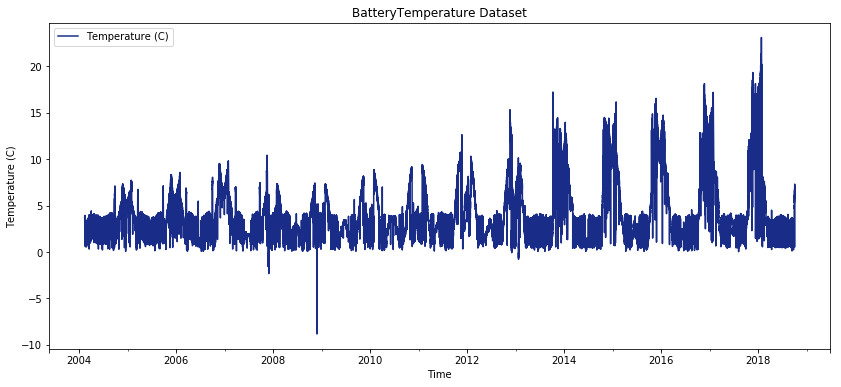

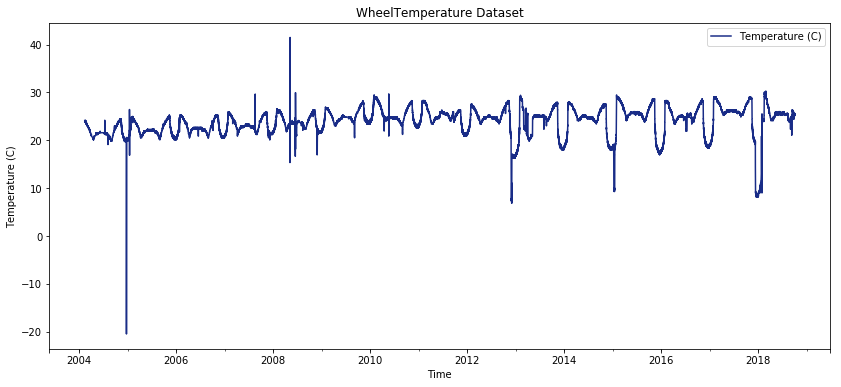

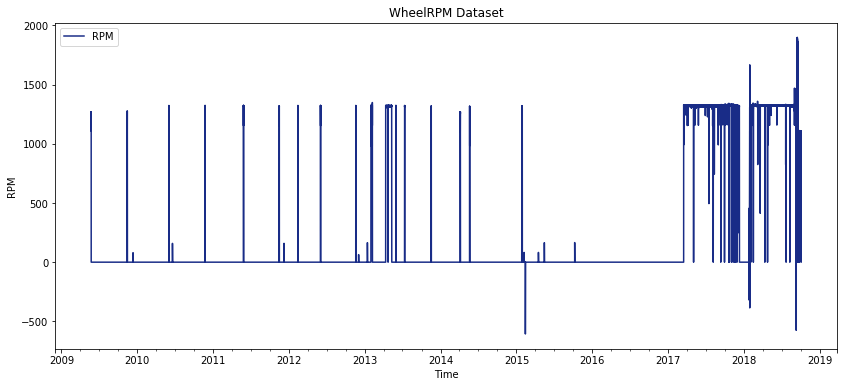

In [4]:
for ds in range(len(datasets)):
    ds_name = dataset[5:-4] # drop 'Data/' and '.csv'

    # Load the dataset
    time_series = read_csv(dataset, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    # Plot the dataset
    ax = time_series.plot(color='#192C87', title=ds_name + ' Dataset', label=var_name, figsize=(14, 6))
    ax.set(xlabel='Time', ylabel=var_name)
    pyplot.legend(loc='best')
    pyplot.show()

## So that's the original data. Next let's create the "normal" models, starting with Rolling Mean:

This rolling mean uses a sliding window of fixed size *L* / 100, where *L* is the length of the dataset.

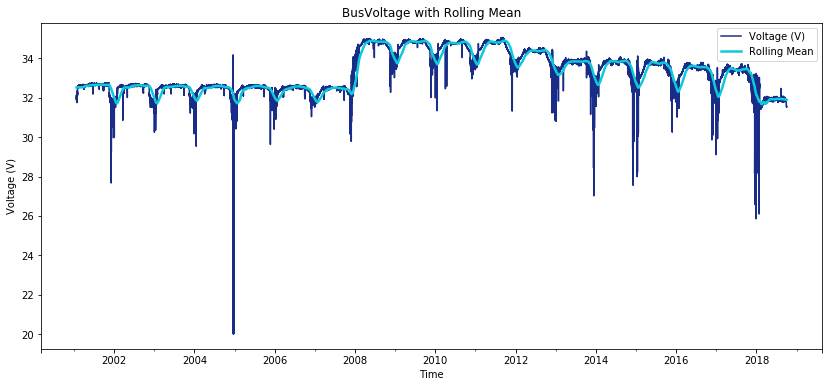

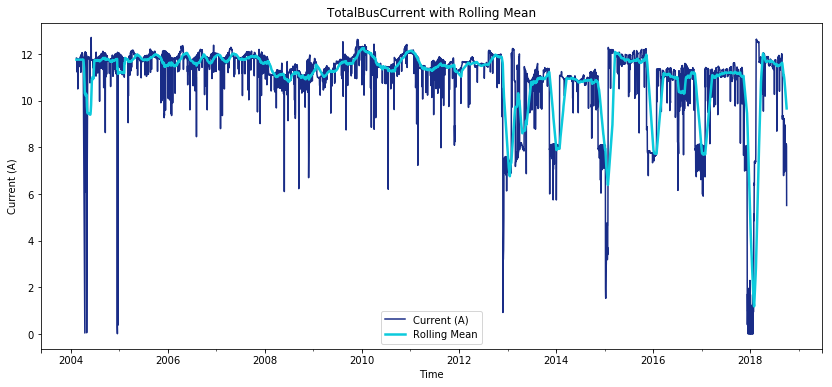

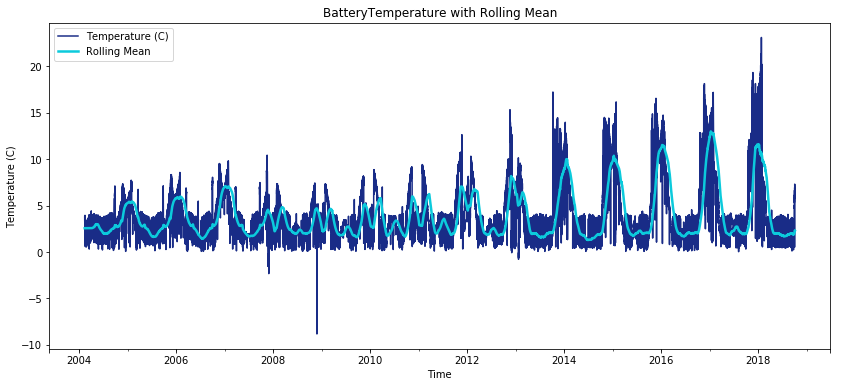

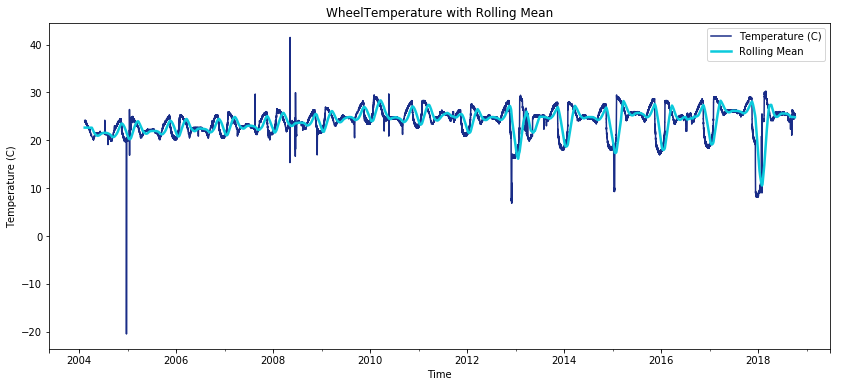

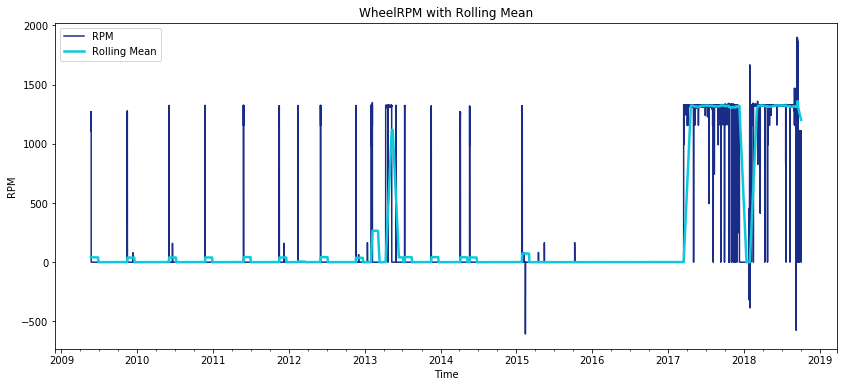

In [5]:
for ds in range(len(datasets)):
    dataset = datasets[ds]
    var_name = var_names[ds]
    ds_name = dataset[5:-4] # drop 'Data/' and '.csv'

    # Load the dataset
    time_series = read_csv(dataset, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    
    window_size = int(len(time_series) / 100)
    # Use custom module 'model_with_rolling_mean' which also saves plots and data 
    ts_with_rolling_mean = model_with_rolling_mean(time_series, window_size, ds_name, var_name=var_name, verbose=True)
    

Now we've stored rolling mean "normal" models. Their CSVs are saved under `./save/datasets/<ds_name>/rolling mean/data/<ds_name>_with_rolling_mean.csv`, where each file is a table with columns [Time, `var_name`, Rolling Mean].

## We can use this saved data to make a table of correlation coefficients:

In [4]:
correlations = pd.DataFrame()

for ds in range(len(datasets)):
    var_name = var_names[ds]
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file_path = 'save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_with_rolling_mean.csv'
    # get correlation coefficient between original data and rolling mean
    coeff = correlation(var_name, file_path, 'Rolling Mean', file_path)
    correlations[ds_name] = 0.0  # add a column with this name
    correlations.at['Rolling Mean', ds_name] = coeff  # Make the index "Rolling Mean" if it doesn't exist, place coeff
    
correlations.to_csv('./save/correlations.csv')
correlations

,BusVoltage,TotalBusCurrent,BatteryTemperature,WheelTemperature,WheelRPM
Rolling Mean,0.926,0.658593,0.712022,0.522871,0.909958


## Continue the "normal" models with Autoregressive Integrated Moving Average (ARIMA):

These ARIMA models use hyperparameters `p,d,q,P,D,Q,m,trend` that were determined by grid searching with nested cross validation—outside this notebook because it's too computationally costly to run here. Unlike a naive rolling mean, ARIMA models are fit with a training set and can then be predicted indefinitely into the future. We'll run ARIMA twice on each dataset; once where the entire dataset is the training set (which will lead to overfitting), and once where just the first half of the dataset is the training set (to examine how well the models predict).

ARIMA is the most computationally costly algorithm of the three here. So costly, in fact, that the algorithm often crashes my latptop before finishing. One model of a telemetry dataset could be on the order of 9GB, and forecasting routinely caused my latptop to use ~70GB of virtual memory. The only way I could complete ARIMA on all five datasets was to downsample each to one data point a day. And the algorithm kept killing this notebook's kernel, so I ran it in an IDE and I'm displaying the saved plot images below.

In [5]:
hyperparams = [
{'order': (1,0,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'},  # orig freq=2920
{'order': (1,0,2), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'},  # orig freq=365
{'order': (0,1,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'n'},  # orig freq=8760
{'order': (1,0,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'},  # orig freq=52560
{'order': (1,0,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'}   # orig freq=105120
]

In [ ]:
# 50% ARIMAs
for ds in range(len(datasets)):
    dataset = datasets[ds]
    var_name = var_names[ds]
    ds_name = dataset[5:-4]  # drop 'Data/' and '.csv'
    order = hyperparams[ds]['order']
    seasonal_order = hyperparams[ds]['seasonal_order']
    freq = hyperparams[ds]['freq']
    trend = hyperparams[ds]['trend']
    print('dataset: ' + dataset)

    # Load the dataset
    time_series = pd.read_csv(dataset, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    # Daily average
    time_series = time_series.resample('24H').mean()

    # Use custom module 'model_with_arima' which also saves plots and data
    blah = model_with_arima(time_series, ds_name=ds_name, train_size=0.5, order=order, seasonal_order=seasonal_order,
                            seasonal_freq=freq, trend=trend,
                            var_name=var_name, verbose=True)

# 100% ARIMAs
for ds in range(len(datasets)):
    dataset = datasets[ds]
    var_name = var_names[ds]
    ds_name = dataset[5:-4]  # drop 'Data/' and '.csv'
    order = hyperparams[ds]['order']
    seasonal_order = hyperparams[ds]['seasonal_order']
    freq = hyperparams[ds]['freq']
    trend = hyperparams[ds]['trend']
    print('dataset: ' + dataset)

    # Load the dataset
    time_series = pd.read_csv(dataset, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    # Daily average
    time_series = time_series.resample('24H').mean()

    # Use custom module 'model_with_arima' which also saves plots and data
    ts_with_forecast = model_with_arima(time_series, ds_name=ds_name, train_size=1, order=order, seasonal_order=seasonal_order,
                            seasonal_freq=freq, trend=trend,
                            var_name=var_name, verbose=True)

<img src="save/datasets/BusVoltage/arima/plots/50 percent/BusVoltage_with_arima_half.png">
<img src="save/datasets/TotalBusCurrent/arima/plots/50 percent/TotalBusCurrent_with_arima_half.png">
<img src="save/datasets/BatteryTemperature/arima/plots/50 percent/BatteryTemperature_with_arima_half.png">
<img src="save/datasets/WheelTemperature/arima/plots/50 percent/WheelTemperature_with_arima_half.png">
<img src="save/datasets/WheelRPM/arima/plots/50 percent/WheelRPM_with_arima_half.png">

<img src="save/datasets/BusVoltage/arima/plots/100 percent/BusVoltage_with_arima_full.png">
<img src="save/datasets/TotalBusCurrent/arima/plots/100 percent/TotalBusCurrent_with_arima_full.png">
<img src="save/datasets/BatteryTemperature/arima/plots/100 percent/BatteryTemperature_with_arima_full.png">
<img src="save/datasets/WheelTemperature/arima/plots/100 percent/WheelTemperature_with_arima_full.png">
<img src="save/datasets/WheelRPM/arima/plots/100 percent/WheelRPM_with_arima_full.png">

## Adding ARIMA to the table of correlation coefficients:

In [6]:
# 100% ARIMAs
for ds in range(len(datasets)):
    var_name = var_names[ds]
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    p = hyperparams[ds]['order'][0]
    freq = hyperparams[ds]['freq']
    drop = 0
    
    file_path = 'save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_with_arima_full.csv'
    if (p == 1):  
        drop = freq  # don't correlate with data that was differenced away
    
    # get correlation coefficient between original data and ARIMA forecast (100%)
    coeff = correlation(var_name, file_path, 'ARIMA', file_path, drop=drop)
    correlations.at['ARIMA (100%)', ds_name] = coeff  # Make the index "ARIMA (100%)" if it doesn't exist, place coeff
    
# 50% ARIMAs
for ds in range(len(datasets)):
    var_name = var_names[ds]
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    p = hyperparams[ds]['order'][0]
    freq = hyperparams[ds]['freq']
    drop = 0
    
    file_path = 'save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_with_arima_half.csv'
    if (p == 1):  
        drop = freq  # don't correlate with data that was differenced away
    
    # get correlation coefficient between original data and ARIMA forecast (50% train & test)
    coeff = correlation(var_name, file_path, 'ARIMA', file_path, drop=drop)
    correlations.at['ARIMA (50% train & test)', ds_name] = coeff  # Make the index "ARIMA (50% train & test)" if it doesn't exist, place coeff
    
for ds in range(len(datasets)):
    var_name = var_names[ds]
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file_path = 'save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_with_arima_half.csv'
    df = read_csv(file_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    drop = int(len(df) / 2)

    # get correlation coefficient between original data and ARIMA forecast (50% train & test)
    coeff = correlation(var_name, file_path, 'ARIMA', file_path, drop=drop)
    correlations.at['ARIMA (50% test)', ds_name] = coeff  # Make the index "ARIMA (50% test)" if it doesn't exist, place coeff
    
correlations.to_csv('./save/correlations.csv')
correlations

,BusVoltage,TotalBusCurrent,BatteryTemperature,WheelTemperature,WheelRPM
Rolling Mean,0.926000,0.658593,0.712022,0.522871,0.909958
ARIMA (100%),0.964081,0.873680,0.953052,0.986575,0.939315
ARIMA (50% train & test),0.438073,-0.186054,0.583154,0.518046,0.274834
ARIMA (50% test),-0.409896,-0.339883,0.409670,0.505791,0.133136


## The last "normal" model algorithm is autoencoder

We're shingling the datasets 18 data points at a time, and the neural network architecture is (18,75,10,75,18). The fitting is done with batch sizes of 50 and 1000 epochs. The data values are normalized between 0–1 to dramatically improve the network's performance.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


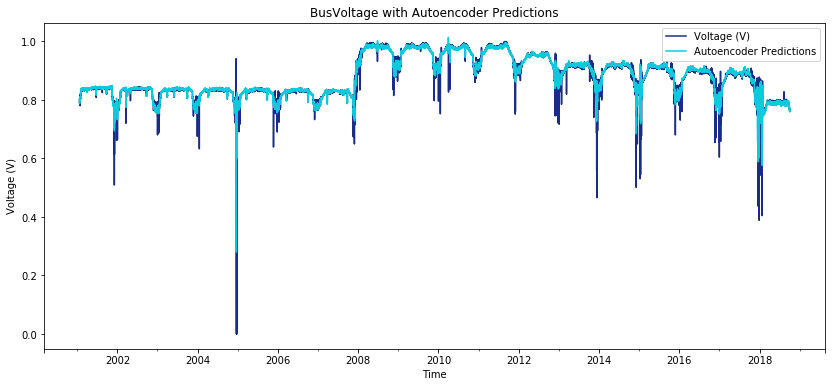

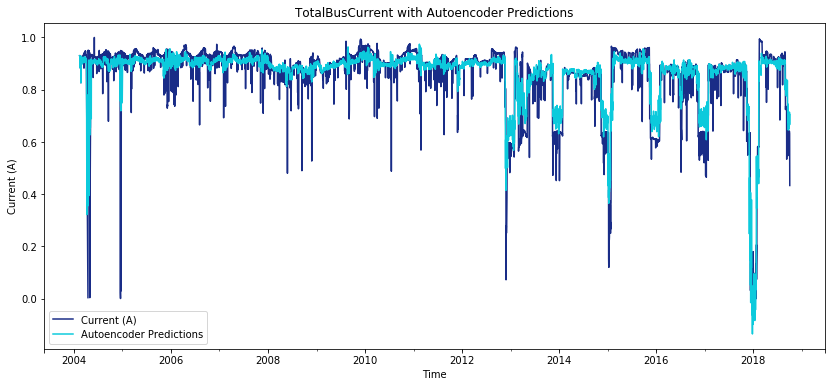

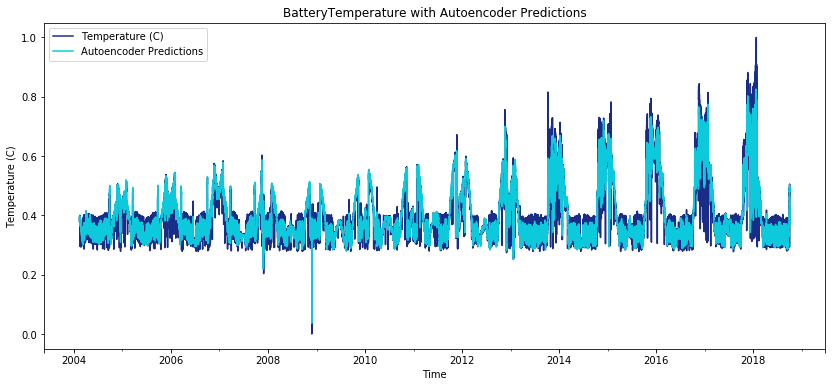

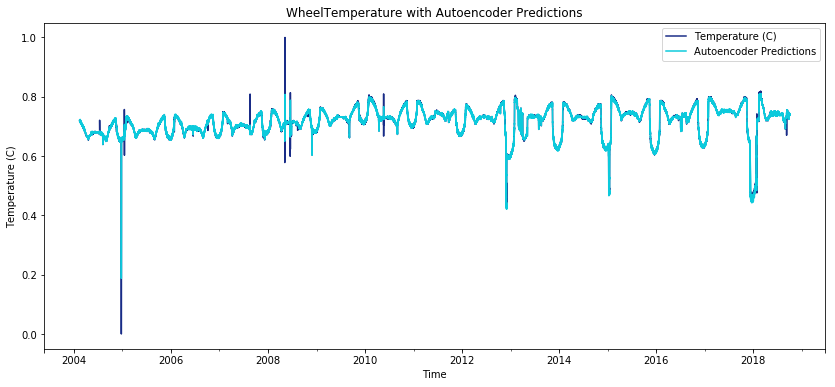

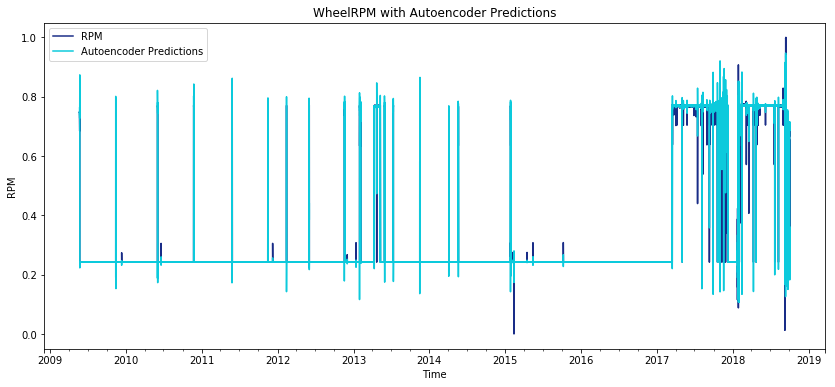

In [4]:
for ds in range(len(datasets)):
    dataset = datasets[ds]
    var_name = var_names[ds]
    ds_name = dataset[5:-4] # drop 'Data/' and '.csv'


    # Use custom module 'model_with_arima' which also saves plots and data 
    ts_with_predictions = autoencoder_prediction(dataset, ds_name, var_name=var_name, verbose=False)

## Add the last row to the table of correlation coefficients:

In [7]:
for ds in range(len(datasets)):
    var_name = var_names[ds]
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file_path = 'save/datasets/' + ds_name + '/autoencoder/data/' + ds_name + '_with_autoencoder.csv'
    # get correlation coefficient between original data and autoencoder prediction
    coeff = correlation(var_name, file_path, 'Autoencoder', file_path)
    correlations.at['Autoencoder', ds_name] = coeff  # Make the index "Autoencoder" if it doesn't exist, place coeff
    
correlations.to_csv('./save/correlations.csv')
correlations  

,BusVoltage,TotalBusCurrent,BatteryTemperature,WheelTemperature,WheelRPM
Rolling Mean,0.926000,0.658593,0.712022,0.522871,0.909958
ARIMA (100%),0.964081,0.873680,0.953052,0.986575,0.939315
ARIMA (50% train & test),0.438073,-0.186054,0.583154,0.518046,0.274834
ARIMA (50% test),-0.409896,-0.339883,0.409670,0.505791,0.133136
Autoencoder,0.979787,0.871307,0.970714,0.998000,0.999488
